In [0]:
!pip install python-igraph

In [0]:
import igraph as ig
from random import random
from tqdm import tqdm
import numpy as np
from copy import copy

# visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# SPEED
#from multiprocessing import Pool

In [0]:
# Nodes are required to have the following values:
# name
# decision - takes a value from [-1, 0, 1] (decline, undecided, buy))
# qexpectation - float between 0 and 1
# Percolation threshold = pc = 0.595

import igraph as ig
from random import uniform


class Model:
  def __init__(self, side_size: int, flag='lat',k=0):
    self.side_size = side_size
    if flag == 'lat':
      self.graph_name = f"Lattice {side_size}x{side_size}"
      self.graph = ig.Graph.Lattice([side_size,side_size])
    elif flag == 'bar':
      self.graph_name = f"Barabasi Albert n={side_size} m=4"
      self.graph = ig.Graph.Barabasi(n=side_size,m=4)
    elif flag == 'wat':
      self.graph_name = f"Watts–Strogatz n={side_size}, k={k}, B=0.01"
      self.graph = ig.Graph.Watts_Strogatz(1,side_size,k,0.01)
    self.reset()
        

  #PRIVATE:
  def _decision(self, qexp, Q):
    """Makes a decision percolate or no
    """
    return qexp < Q

  #PUBLIC:
  def reset(self):
    """Resets model to its initial state
    """
    for v in self.graph.vs:
      v['decision'] = 0
    self.graph.vs[int(self.side_size/2)]['decision'] = 1

  def get_GC_size(self):
    """Returns size of the giant component
    """
    return len(self.graph.vs.select(decision=1))

  def one_step(self, q):
    """Makes one small step
    """
    nodes = self.graph.vs.select(decision=1) #Get nodes that bought product
    for node in nodes: #iterate over each node
      neighbors = list((filter(lambda x: x['decision'] == 0, node.neighbors())))#Get its neighbors that not decided
      for neighbor in neighbors: #iterate over each neighbor
        if self._decision(random(), q):
          neighbor['decision'] = 1 #customer buys product
        else:
          neighbor['decision'] = -1 #customer doesn't buy product


  def steps(self, prev_n: [ig.Vertex], q: float):
    """Makes one Mote-Carlo step
    """
    if (not prev_n):
      pass
    else:
      next_n = set()
      for n in prev_n:
        neighbours = n.neighbors()
        if self._decision(random(), q):
          n['decision'] = 1
          next_n.update(set(neighbours))
        else:
          n['decision'] = -1   
      next_n = list((filter(lambda x: x['decision'] == 0, next_n)))
      self.steps(next_n, q)


  def lattice_to_array(self):
    array = []
    for i in range(self.side_size):
      row = []
      for j in range(self.side_size):
        row.append(self.graph.vs.find(f'{i},{j}')['decision'])
        array.append(row)
    return array

In [0]:
### Helper functions

def find_pc(gcsizes):
  biggest = 0
  max_diff = 0
  for i, s in enumerate(gcsizes[1:]):
    diff = abs(s-gcsizes[i])
    if max_diff < diff:
      biggest = i
      max_diff = diff
  return biggest

# Percolation Threshold

In [0]:
network = Model(200,flag='lat')

In [0]:
Qs = np.linspace(0.4,0.8,60)

avgs=[]
for Q in tqdm(Qs):
  for _ in range(30):
    gcsizes = []
    network.steps(network.graph.vs.select(decision=1)[0].neighbors(), Q)
    gcsizes.append(network.get_GC_size())
    network.reset()
  avgs.append(np.mean(gcsizes))

No handles with labels found to put in legend.


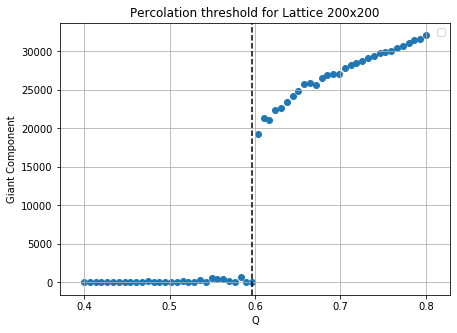

In [0]:
plt.figure(figsize=(7,5))
plt.title(f"Percolation threshold for {network.graph_name}")
plt.xlabel("Q")
plt.ylabel("Giant Component")
plt.grid()

plt.axvline(x=Qs[find_pc(avgs)], color='k', linestyle='--')
plt.scatter(Qs, avgs)
plt.legend()

## Sales Curves Generation

In [0]:
network = Model(100,flag='lat')

In [0]:
pc = 0.597
Qs = [pc-0.05, pc, pc+0.05]
steps = 300

network.reset()

n_customers = []

for i,Q in enumerate(Qs):
  print(Q)
  n_customers_per_timestep = np.zeros(steps)
  new_customers = 0
  customers = 0
  for istep in range(steps):
    network.one_step(Q)
    gc = network.get_GC_size()
    new_customers = gc - customers
    customers = gc
    if new_customers == 0:
      break
    n_customers_per_timestep[istep] = new_customers
  n_customers.append(n_customers_per_timestep)
  network.reset()


0.5469999999999999
0.597
0.647


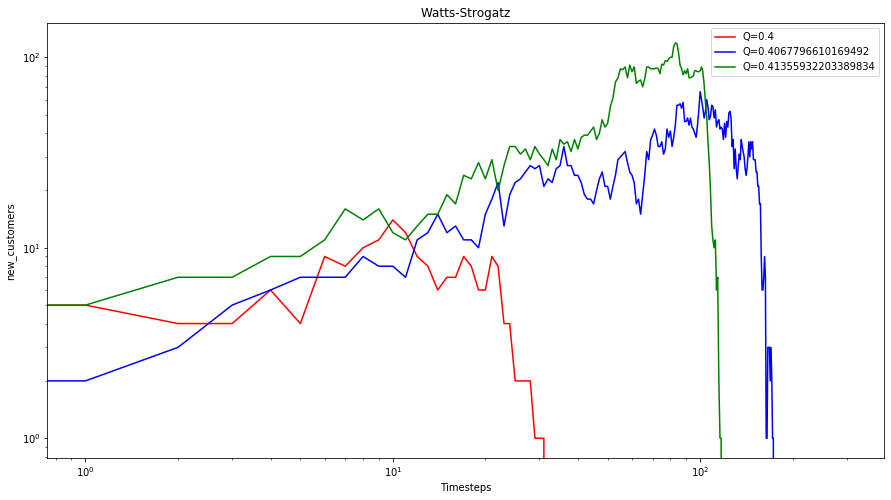

In [0]:
plt.figure(figsize=(15,8))
colors = ['r','b','g']
width = 0.33
for i, n in enumerate(n_customers):
  plt.plot(np.arange(0,len(n)), n, label= f"Q={Qs[i]}",color=colors[i])
plt.xlabel("Timesteps")
plt.ylabel("new_customers")
plt.title("Watts-Strogatz")
plt.xscale('log')
plt.yscale('log')
plt.legend()